# 神经网络进行分类

本节内容是根据文本的词袋模型（什么是词袋模型？）来进行建模，然后利用神经网络来对文本进行分类。


## 1. 神经网络分类器

首先需要学习神经网络进行分类的一般方法

从例子出发，假设我们有一个关于病人基本信息及其是否患有恶性肿瘤的数据库，如下


<img src="disease.jpg" alt="病人信息数据库" width=500 style=display:inline-block>

表中给出了若干病人年龄、肿瘤尺寸以及是否是恶性的诊断数据，这些数据可以用来预测一个新病人的肿瘤是否为恶性。

在这个例子中，年龄和肿瘤尺寸都是特征变量，而是否为恶性肿瘤是我们关注的目标变量，这种目标变量只在0和1之间取值，这种数据也叫做标签。

神经网络要学习的是从特征变量到目标变量之间的映射。

### 1.1 如何利用神经网络进行分类

像处理预测问题一样，搭建人工神经网络进行分类。 其中输入神经元对应特征变量的数量，输出神经元的数量一般要和目标类别数一致。 比如，在肿瘤预测中，我们要将结果分为两类的话，输出神经元的个数就是2。


与预测神经网络的输出层不同，分类神经网络的输出层虽然也是一个实数，但它的取值范围是（0,1）区间中的一个实数，而且要求输出单元的所有输出值之和为1。我们要从所有的输出中选择一个数值最大的进行输出，它所对应的神经元编号就是神经网络给出的最后类别。

因为输出是互斥的，所以相当于输出的是概率最大的那个结果。


<img src="pic1.jpg" alt="基础分类" width=500 style=display:inline-block>

比如，针对上面的肿瘤分类问题，我们可以构造一个包含2个输入单元、3个隐含单元、2个输出单元的神经网。上面就是最终结果之和为1，恶性概率0.8大于良性0.2，所以最终的判断就是0，即“恶性”。

之前使用了sigmoid函数（可以输出0-1之间），但是不能保证输出的两个神经元数值之和为1。所以这时要选择常用的softmax函数（归一化指数函数），

它的表达式为：$$\mathbf{\frac{e^{x_i}}{\sum_{i=1}^{n} e^{x_i}}}$$

假如输出单元的输入是 x = [[$x_1$,$x_2$]],那么通过如下可以完成softmax函数
]


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

下面实现softmax函数

In [16]:
x1 = np.linspace(-10, 10, 100)
x2 = np.zeros_like(x1) 
x = torch.tensor([x1, x2], dtype=torch.float32).T  #为什么这里要转置？？

在PyTorch中，torch.nn.functional.softmax 函数的 dim 参数表示要在哪个维度上计算 softmax。在这个例子中，我们有一个大小为 (100, 2) 的张量 x，其中 100 表示样本数，2 表示每个样本有两个特征。我们希望对每个样本的特征维度进行 softmax 操作，因此我们选择 dim=1。

然而，torch.nn.functional.softmax 函数默认操作的是最后一个维度，因此我们需要确保特征维度是最后一个维度。因此，我们在创建 x 时使用了 .T（转置），将原先的 (2, 100) 转置成 (100, 2)。

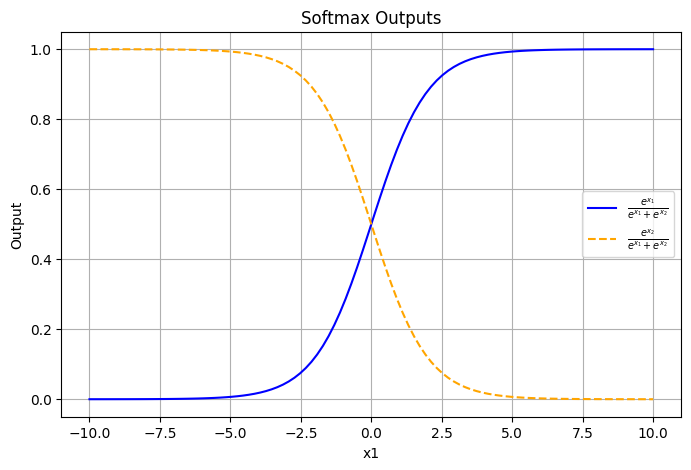

In [18]:
y = torch.nn.functional.softmax(x, dim=1)
#y 是经过 softmax 操作后的输出，y[:, 0] 表示对每个样本的第一个特征进行 softmax 操作的结果
#y[:, 1] 表示对每个样本的第二个特征进行 softmax 操作的结果。


plt.figure(figsize=(8, 5))

plt.plot(x1, y[:, 0].numpy(), label=r'$\frac{e^{x_1}}{e^{x_1}+e^{x_2}}$', linestyle='-', color='blue')

plt.plot(x1, y[:, 1].numpy(), label=r'$\frac{e^{x_2}}{e^{x_1}+e^{x_2}}$', linestyle='--', color='orange')

plt.title('Softmax Outputs')
plt.xlabel('x1')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

当输出单元为2个的时候，softmax函数式两条曲线。横坐标为$x_1$,纵坐标为$y_1,y_2$,分别表示第一个和第二个神经元的输出值。

其中$x_1$是从[-10,10]中取值，$x_2$始终等于0

softmax函数和sigmoid函数都能起到非线性映射的作用。同时，由于softmax函数包含了指数函数exp，所以它的输出必然大于0；又因为softmax函数的每一项都要除以一个归一化因子，所以这个形式自然保证了输出值之和必然为1。

接下来，可以按照输出值最大元素来做分类预测，使用以下语句可以完成：

<center><strong>y = torch.nn.functional.softmax(x,dim=1)</strong></center>
                        
<center><strong>c = torch.max(y, 0)[1] # c 的值将是一个包含每个样本最大概率的类别索引的张量</strong></center>

举个例子：

                            # 假设 y 是一个包含类别概率分布的张量
                        y = torch.tensor([[0.2, 0.5, 0.3],
                                          [0.7, 0.1, 0.2],
                                          [0.3, 0.2, 0.5]])
                        
                        # 从每个样本的类别分布中抽取一个样本
                        c = torch.multinomial(y, 1)
                        结果就是  tensor([1, 0, 2])

)


torch.max(y, 0) 返回的是一个包含两个张量的元组 (最大值, 最大值的索引) 所以这样就可以返回对应的索引了

因为结果之和为1，跟概率的解释一致，所以我们也可以根据概率来分类

<center><strong>y = torch.nn.functional.softmax(x,dim=1)</strong></center>
                        
<center><strong>c = torch.multinomial(y,1) # 从每个样本的类别分布中抽取一个样本</strong></center>

举个例子：

                        
                        # 假设 y 是一个包含类别概率分布的张量
                        y = torch.tensor([[0.2, 0.5, 0.3],
                                          [0.7, 0.1, 0.2],
                                          [0.3, 0.2, 0.5]])
                        
                        # 从每个样本的类别分布中抽取一个样本
                        c = torch.multinomial(y, 1)
                        
                        print(c)
                        tensor([[1],
                                [0],
                                [2]])


torch.multinomial(y,1)的作用是以为概率输出类别编号，而且，对于同样的，每次运行得到的都不一样。因此，multinomial的作用就相当于一次依概率分布的采样，第二个参数1表示我们需要的采样个数为1。